In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import re
import seaborn as sns
from datetime import datetime
from plotnine import *

In [2]:
train_raw = pd.read_csv('train.csv').drop("weights", axis = 1)
test_raw = pd.read_csv('test.csv')
test_train = pd.concat([test_raw, train_raw.drop('y', axis = 1)]).reset_index(drop = True)
test_train.head()

,X1jan2018,X2jan2018,X3jan2018,X4jan2018,X5jan2018,X6jan2018,X7jan2018,X8jan2018,X9jan2018,X10jan2018,...,BILLING,PAYMENT,TYPE_OFFER,FAMILY_OFFER,CAP,CITY,PROVINCE,REGION,ALTIMETRIC_ZONE,CLIMATE_ZONE
0,4.535,8.675,13.994,11.765,7.798,8.437,5.210,7.153,7.337,9.480,...,BIMESTRALE,BOLLETTINO POSTALE,Prezzo fisso,Fixa,89030,SAN LUCA,RC,CALABRIA,Montagna Litoranea,C
1,9.396,8.683,5.110,5.397,7.530,3.551,6.719,4.536,9.743,7.446,...,BIMESTRALE,BOLLETTINO POSTALE,Prezzo fisso,Fixa,84014,NOCERA INFERIORE,SA,CAMPANIA,Pianura,C
2,7.804,7.778,6.695,6.988,7.422,5.485,7.588,7.531,5.880,7.685,...,BIMESTRALE,DOMICILIAZIONE,Prezzo fisso,Fixa,98057,MILAZZO,ME,SICILIA,Collina Litoranea,B
3,13.991,8.174,5.616,5.636,5.609,5.615,5.557,5.538,5.534,5.673,...,BIMESTRALE,BOLLETTINO POSTALE,Prezzo fisso,Fixa,55,LADISPOLI,RM,LAZIO,Collina Litoranea,C
4,7.750,7.262,9.756,8.002,10.012,9.421,9.008,8.041,7.244,7.005,...,BIMESTRALE,DOMICILIAZIONE,Prezzo fisso,Fixa,98057,MILAZZO,ME,SICILIA,Collina Litoranea,B


In [3]:
test_train.shape

(14810, 378)

In [4]:
map_df = gpd.read_file("ITA_adm/ITA_adm2.shp")
map_df.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,TYPE_2,ENGTYPE_2,NL_NAME_2,VARNAME_2,geometry
0,112,ITA,Italy,1,Abruzzo,1,Chieti,Provincia,Province,None,None,"POLYGON ((14.2540273666383 42.44513702392578, ..."
1,112,ITA,Italy,1,Abruzzo,2,L'Aquila,Provincia,Province,None,Aquila,"POLYGON ((13.40441417694103 42.57731246948254,..."
2,112,ITA,Italy,1,Abruzzo,3,Pescara,Provincia,Province,None,None,"POLYGON ((14.07482624053961 42.54282379150396,..."
3,112,ITA,Italy,1,Abruzzo,4,Teramo,Provincia,Province,None,None,"POLYGON ((13.91541576385492 42.89561080932623,..."
4,112,ITA,Italy,2,Apulia,5,Bari,Provincia,Province,None,None,"(POLYGON ((17.2836971282959 40.77928161621099,..."


In [5]:
abrrev_df = pd.read_csv("abbrev.csv")
abrrev_df.head()

,Province,Code,Region,CAP capital towns,CAP other towns
0,Roma,RM,Lazio,001xx (00118 to 00199),000xx (00010 to 00069)
1,Vatican City,SCV,-,120,-
2,Viterbo,VT,Lazio,1100,010xx (01010 to 01039)
3,Rieti,RI,Lazio,2100,020xx (02010 to 02049)
4,Frosinone,FR,Lazio,3100,030xx (03010 to 03049)


In [6]:
code_dict = {row["Code"]: row["Province"] for index, row in abrrev_df.iterrows()}

### Province in train_raw but not in code dictionary

In [7]:
train_raw[train_raw["PROVINCE"].apply(lambda province: province not in code_dict)]

,y,X1jan2018,X2jan2018,X3jan2018,X4jan2018,X5jan2018,X6jan2018,X7jan2018,X8jan2018,X9jan2018,...,BILLING,PAYMENT,TYPE_OFFER,FAMILY_OFFER,CAP,CITY,PROVINCE,REGION,ALTIMETRIC_ZONE,CLIMATE_ZONE
1785,1.165,3.087,3.81,3.642,2.9,3.056,2.966,3.237,3.182,3.772,...,BIMESTRALE,DOMICILIAZIONE,Prezzo indicizzato,Sottocontrollo,9016,IGLESIAS,SU,SARDEGNA,Collina Litoranea,C


In [8]:
code_dict["LI"] = "Livorno"
code_dict["RC"] = "Reggio Di Calabria"
code_dict["RE"] = "Reggio Nell'Emilia"
code_dict["TO"] = "Torino"
code_dict["GE"] = "Genova"
code_dict["BZ"] = "Bolzano"

In [9]:
test_train["PROVINCE_NAME"] = test_train["PROVINCE"].apply(lambda province: code_dict.get(province, None))
first_day_idx = test_train.columns.get_loc("X1jan2018")
last_day_idx = test_train.columns.get_loc("X31dec2018")
column_select =  test_train.columns[first_day_idx : last_day_idx + 1].tolist() + ["PROVINCE_NAME"]
test_train_map_df = test_train.loc[~test_train["PROVINCE"].isin(["FI", "SU"]), column_select] # "FI", "SU" cannot be properly mapped but the relative observations are few.
test_train_map_df.head()

,X1jan2018,X2jan2018,X3jan2018,X4jan2018,X5jan2018,X6jan2018,X7jan2018,X8jan2018,X9jan2018,X10jan2018,...,X23dec2018,X24dec2018,X25dec2018,X26dec2018,X27dec2018,X28dec2018,X29dec2018,X30dec2018,X31dec2018,PROVINCE_NAME
0,4.535,8.675,13.994,11.765,7.798,8.437,5.210,7.153,7.337,9.480,...,11.428,15.000,15.151,10.770,11.674,17.264,11.236,12.223,20.616,Reggio Di Calabria
1,9.396,8.683,5.110,5.397,7.530,3.551,6.719,4.536,9.743,7.446,...,7.119,7.859,5.140,11.254,10.233,5.635,7.731,11.235,5.181,Salerno
2,7.804,7.778,6.695,6.988,7.422,5.485,7.588,7.531,5.880,7.685,...,6.517,7.410,5.551,6.687,6.681,6.039,7.389,6.839,7.823,Messina
3,13.991,8.174,5.616,5.636,5.609,5.615,5.557,5.538,5.534,5.673,...,6.950,7.343,7.159,13.053,10.449,4.976,9.304,5.083,4.746,Roma
4,7.750,7.262,9.756,8.002,10.012,9.421,9.008,8.041,7.244,7.005,...,10.452,7.736,8.088,10.030,4.572,8.996,8.586,9.493,7.505,Messina


In [10]:
test_train_map_df[~test_train_map_df["PROVINCE_NAME"].isin(map_df["NAME_2"])]

,X1jan2018,X2jan2018,X3jan2018,X4jan2018,X5jan2018,X6jan2018,X7jan2018,X8jan2018,X9jan2018,X10jan2018,...,X23dec2018,X24dec2018,X25dec2018,X26dec2018,X27dec2018,X28dec2018,X29dec2018,X30dec2018,X31dec2018,PROVINCE_NAME


In [11]:
def geo_map(month, data_df, map_df, ax):
    import matplotlib.pyplot as plt
    import pandas as pd
    
    data_select_df = pd.concat([data_df.loc[:, data_df.columns.str.contains(month)], data_df["PROVINCE_NAME"]], axis = 1)
    monthly_mean_ser = data_select_df.groupby(["PROVINCE_NAME"]).mean().mean(axis = 1)
    merged = map_df.merge(monthly_mean_ser.rename(month), left_on = "NAME_2", right_index = True)
    
    variable = month

    merged.plot(column = variable, cmap = "Reds", linewidth = 0.8, ax = ax, edgecolor = "0.8", legend = True, vmin = 0, vmax = 12)

    ax.axis("off")
    ax.set_title(month.upper(), fontdict={"fontsize": "15", "fontweight" : "15"})

In [12]:
months = pd.Series([re.sub("[0-9X]", "", date) for date in test_train_map_df.columns.drop("PROVINCE_NAME")]).unique()

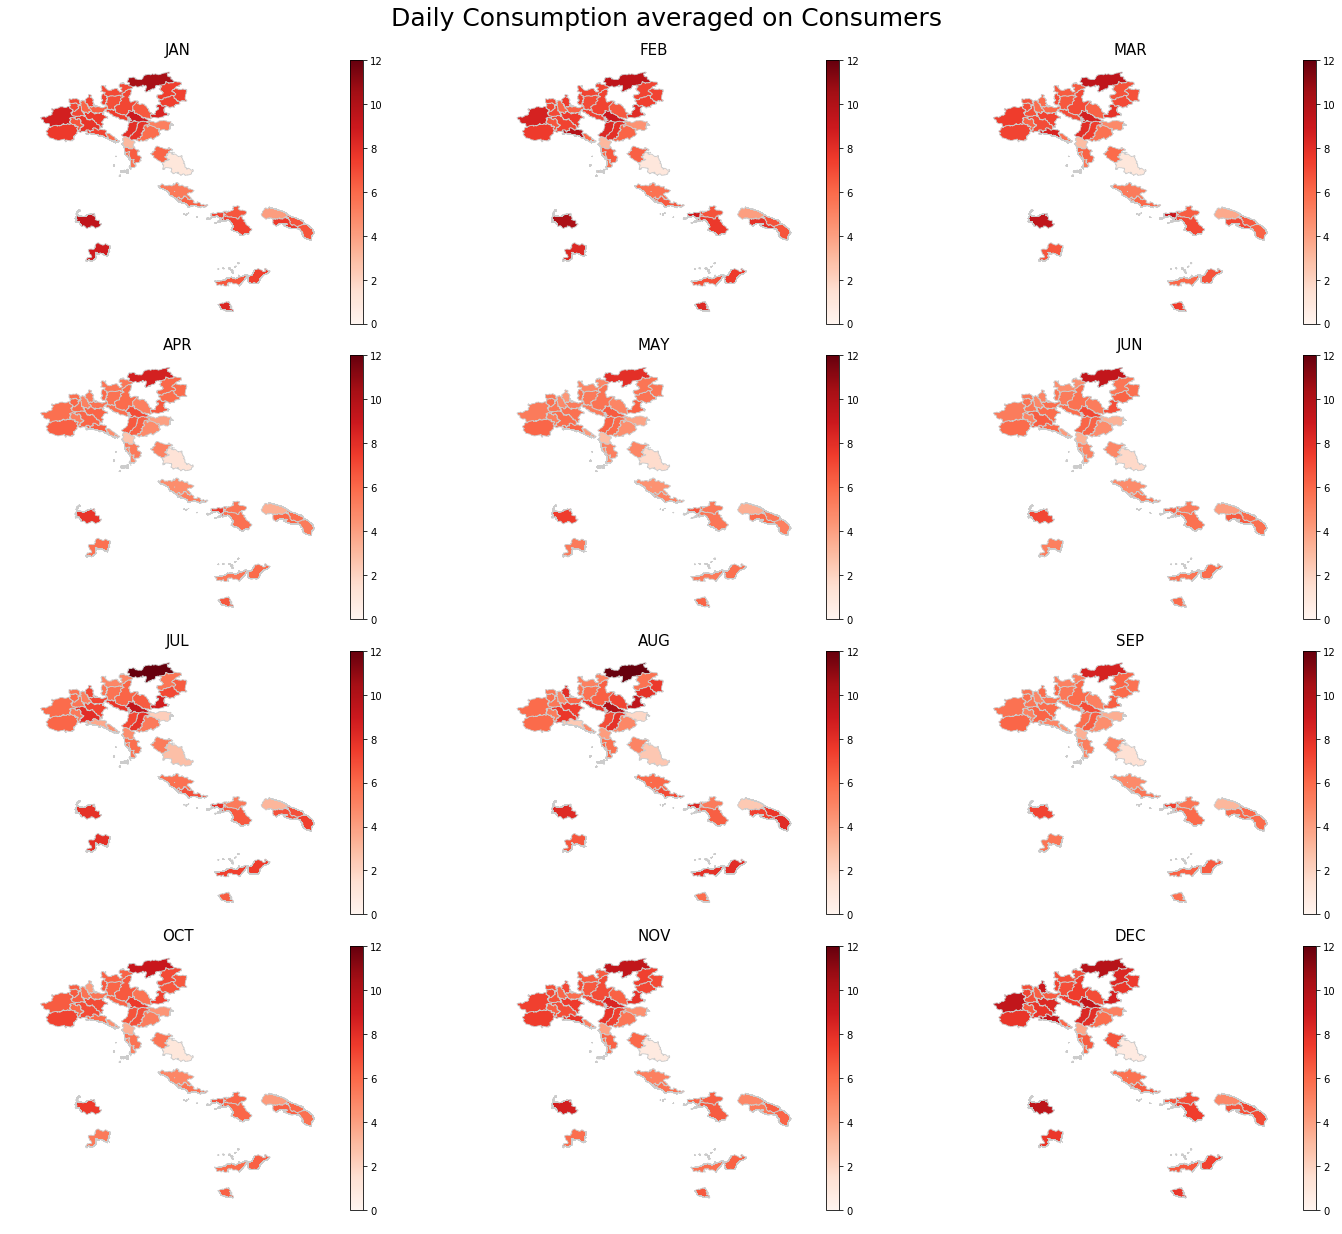

In [13]:
fig, ax = plt.subplots(nrows = 4, ncols = 3, figsize = (20, 18))
fig.suptitle("Daily Consumption averaged on Consumers", fontsize = 25, weight = 25)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
for idx, month in enumerate(months):
    geo_map(month, test_train_map_df, map_df, ax[idx // 3, idx % 3])
plt.savefig("geomap.png", dpi = 500)

In [14]:
def corr_plot(month, data_df, ax):
    import seaborn as sns
    
    sns.heatmap(np.corrcoef(test_train_map_df.loc[:, test_train_map_df.columns.str.contains(month)].dropna().T), ax = ax)
    ax.set_title(month.upper(), fontdict={"fontsize": "15", "fontweight" : "15"})

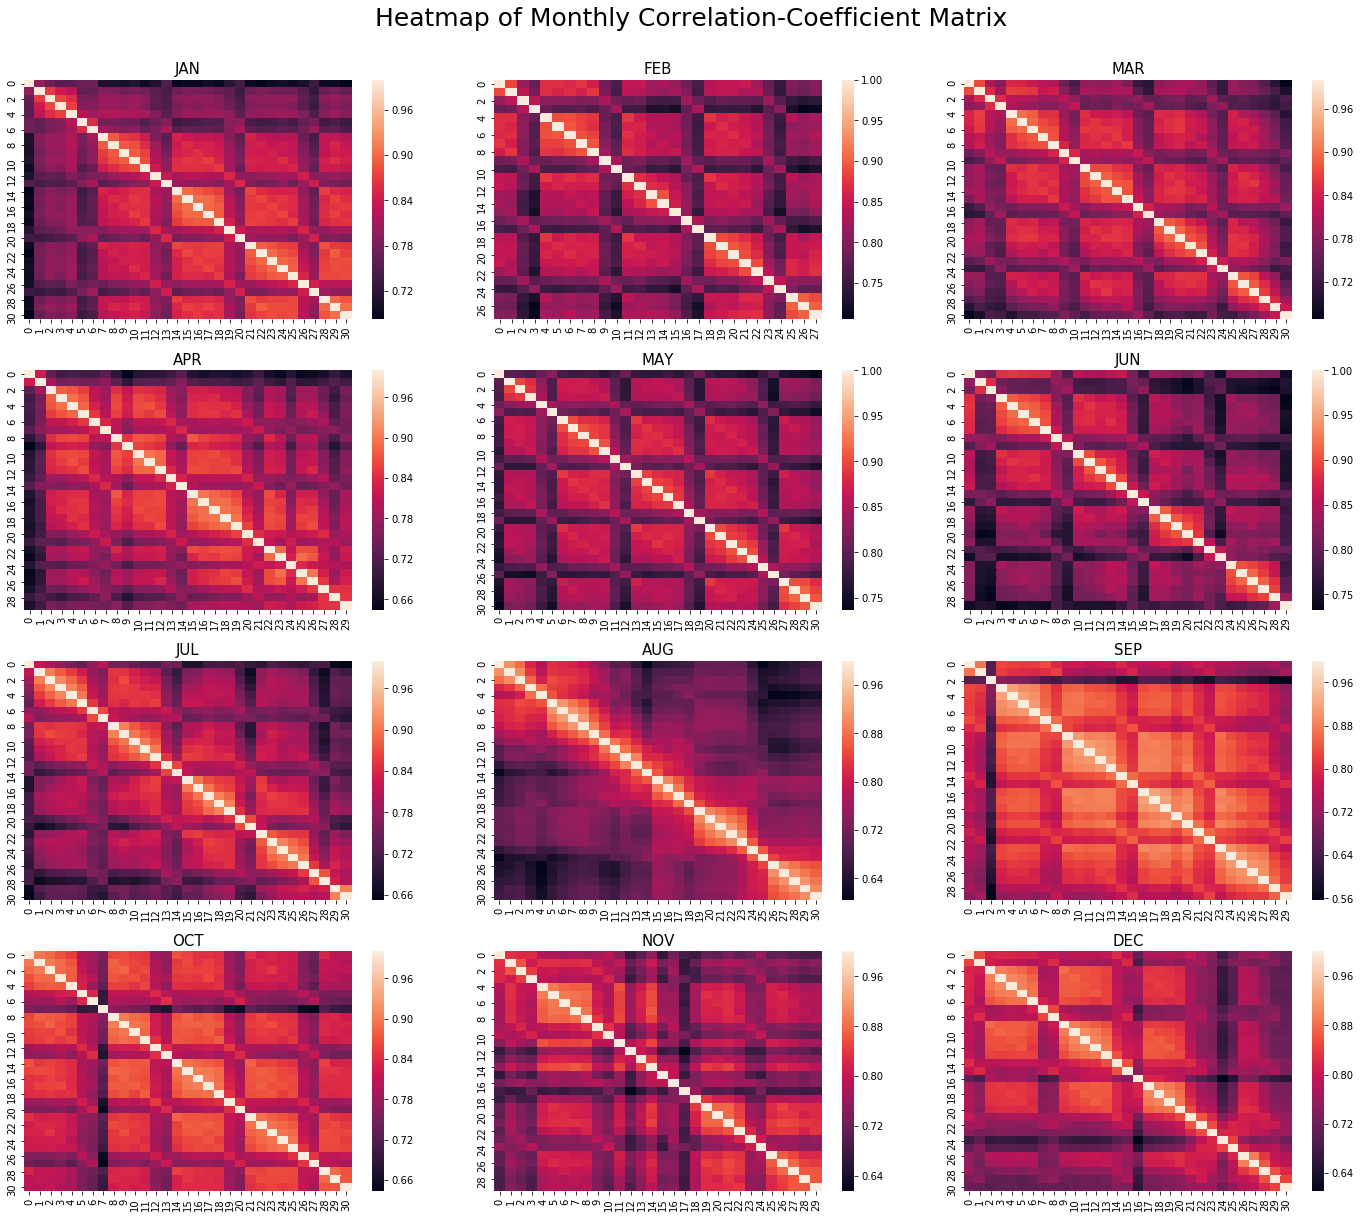

In [15]:
fig, ax = plt.subplots(nrows = 4, ncols = 3, figsize = (20, 18))
fig.tight_layout(rect=[0, 0.03, 1, 0.95], pad = 3)
fig.suptitle("Heatmap of Monthly Correlation-Coefficient Matrix", fontsize = 25, weight = 25)
for idx, month in enumerate(months):
    corr_plot(month, test_train_map_df, ax[idx // 3, idx % 3])
plt.savefig("corrplot.png", dpi = 500)

In [16]:
id_vars = ["index"] + test_train.columns[last_day_idx + 1:].tolist()

In [17]:
test_train_long = pd.melt(pd.concat([test_train.iloc[:, first_day_idx : last_day_idx + 1], test_train.loc[:, "TYPE_CUST":]], axis = 1).reset_index(), id_vars = id_vars, var_name = "date", value_name = "KWH")
test_train_long.head()

,index,TYPE_CUST,GENDER,AGE_CUST,BILLING,PAYMENT,TYPE_OFFER,FAMILY_OFFER,CAP,CITY,PROVINCE,REGION,ALTIMETRIC_ZONE,CLIMATE_ZONE,PROVINCE_NAME,date,KWH
0,0,RESIDENZIALI,F,75.84,BIMESTRALE,BOLLETTINO POSTALE,Prezzo fisso,Fixa,89030,SAN LUCA,RC,CALABRIA,Montagna Litoranea,C,Reggio Di Calabria,X1jan2018,4.535
1,1,RESIDENZIALI,M,NaN,BIMESTRALE,BOLLETTINO POSTALE,Prezzo fisso,Fixa,84014,NOCERA INFERIORE,SA,CAMPANIA,Pianura,C,Salerno,X1jan2018,9.396
2,2,RESIDENZIALI,F,59.80,BIMESTRALE,DOMICILIAZIONE,Prezzo fisso,Fixa,98057,MILAZZO,ME,SICILIA,Collina Litoranea,B,Messina,X1jan2018,7.804
3,3,RESIDENZIALI,NaN,NaN,BIMESTRALE,BOLLETTINO POSTALE,Prezzo fisso,Fixa,55,LADISPOLI,RM,LAZIO,Collina Litoranea,C,Roma,X1jan2018,13.991
4,4,RESIDENZIALI,F,66.44,BIMESTRALE,DOMICILIAZIONE,Prezzo fisso,Fixa,98057,MILAZZO,ME,SICILIA,Collina Litoranea,B,Messina,X1jan2018,7.750


In [18]:
test_train_long["date"] = pd.to_datetime(test_train_long["date"], format = 'X%d%b%Y')
test_train_long["weekday"] = test_train_long["date"].apply(lambda date: date.weekday() in range(5))
test_train_long["month"] = test_train_long["date"].apply(lambda date: date.month)
test_train_long.head()

,index,TYPE_CUST,GENDER,AGE_CUST,BILLING,PAYMENT,TYPE_OFFER,FAMILY_OFFER,CAP,CITY,PROVINCE,REGION,ALTIMETRIC_ZONE,CLIMATE_ZONE,PROVINCE_NAME,date,KWH,weekday,month
0,0,RESIDENZIALI,F,75.84,BIMESTRALE,BOLLETTINO POSTALE,Prezzo fisso,Fixa,89030,SAN LUCA,RC,CALABRIA,Montagna Litoranea,C,Reggio Di Calabria,2018-01-01,4.535,True,1
1,1,RESIDENZIALI,M,NaN,BIMESTRALE,BOLLETTINO POSTALE,Prezzo fisso,Fixa,84014,NOCERA INFERIORE,SA,CAMPANIA,Pianura,C,Salerno,2018-01-01,9.396,True,1
2,2,RESIDENZIALI,F,59.80,BIMESTRALE,DOMICILIAZIONE,Prezzo fisso,Fixa,98057,MILAZZO,ME,SICILIA,Collina Litoranea,B,Messina,2018-01-01,7.804,True,1
3,3,RESIDENZIALI,NaN,NaN,BIMESTRALE,BOLLETTINO POSTALE,Prezzo fisso,Fixa,55,LADISPOLI,RM,LAZIO,Collina Litoranea,C,Roma,2018-01-01,13.991,True,1
4,4,RESIDENZIALI,F,66.44,BIMESTRALE,DOMICILIAZIONE,Prezzo fisso,Fixa,98057,MILAZZO,ME,SICILIA,Collina Litoranea,B,Messina,2018-01-01,7.750,True,1


In [19]:
data_time_series_TYPE_CUST = test_train_long[ ["date", "TYPE_CUST", "KWH", "weekday"] ].groupby(["date", "TYPE_CUST"]).mean().reset_index()
data_time_series_TYPE_CUST["month"] = data_time_series_TYPE_CUST["date"].apply(lambda date: date.month)
data_time_series_TYPE_CUST.head()

,date,TYPE_CUST,KWH,weekday,month
0,2018-01-01,CONDOMINIO,1.938115,True,1
1,2018-01-01,IMPRESE,3.377750,True,1
2,2018-01-01,MICROBUSINESS,4.589567,True,1
3,2018-01-01,MULTISITO,1.798798,True,1
4,2018-01-01,RESIDENZIALI,6.938604,True,1


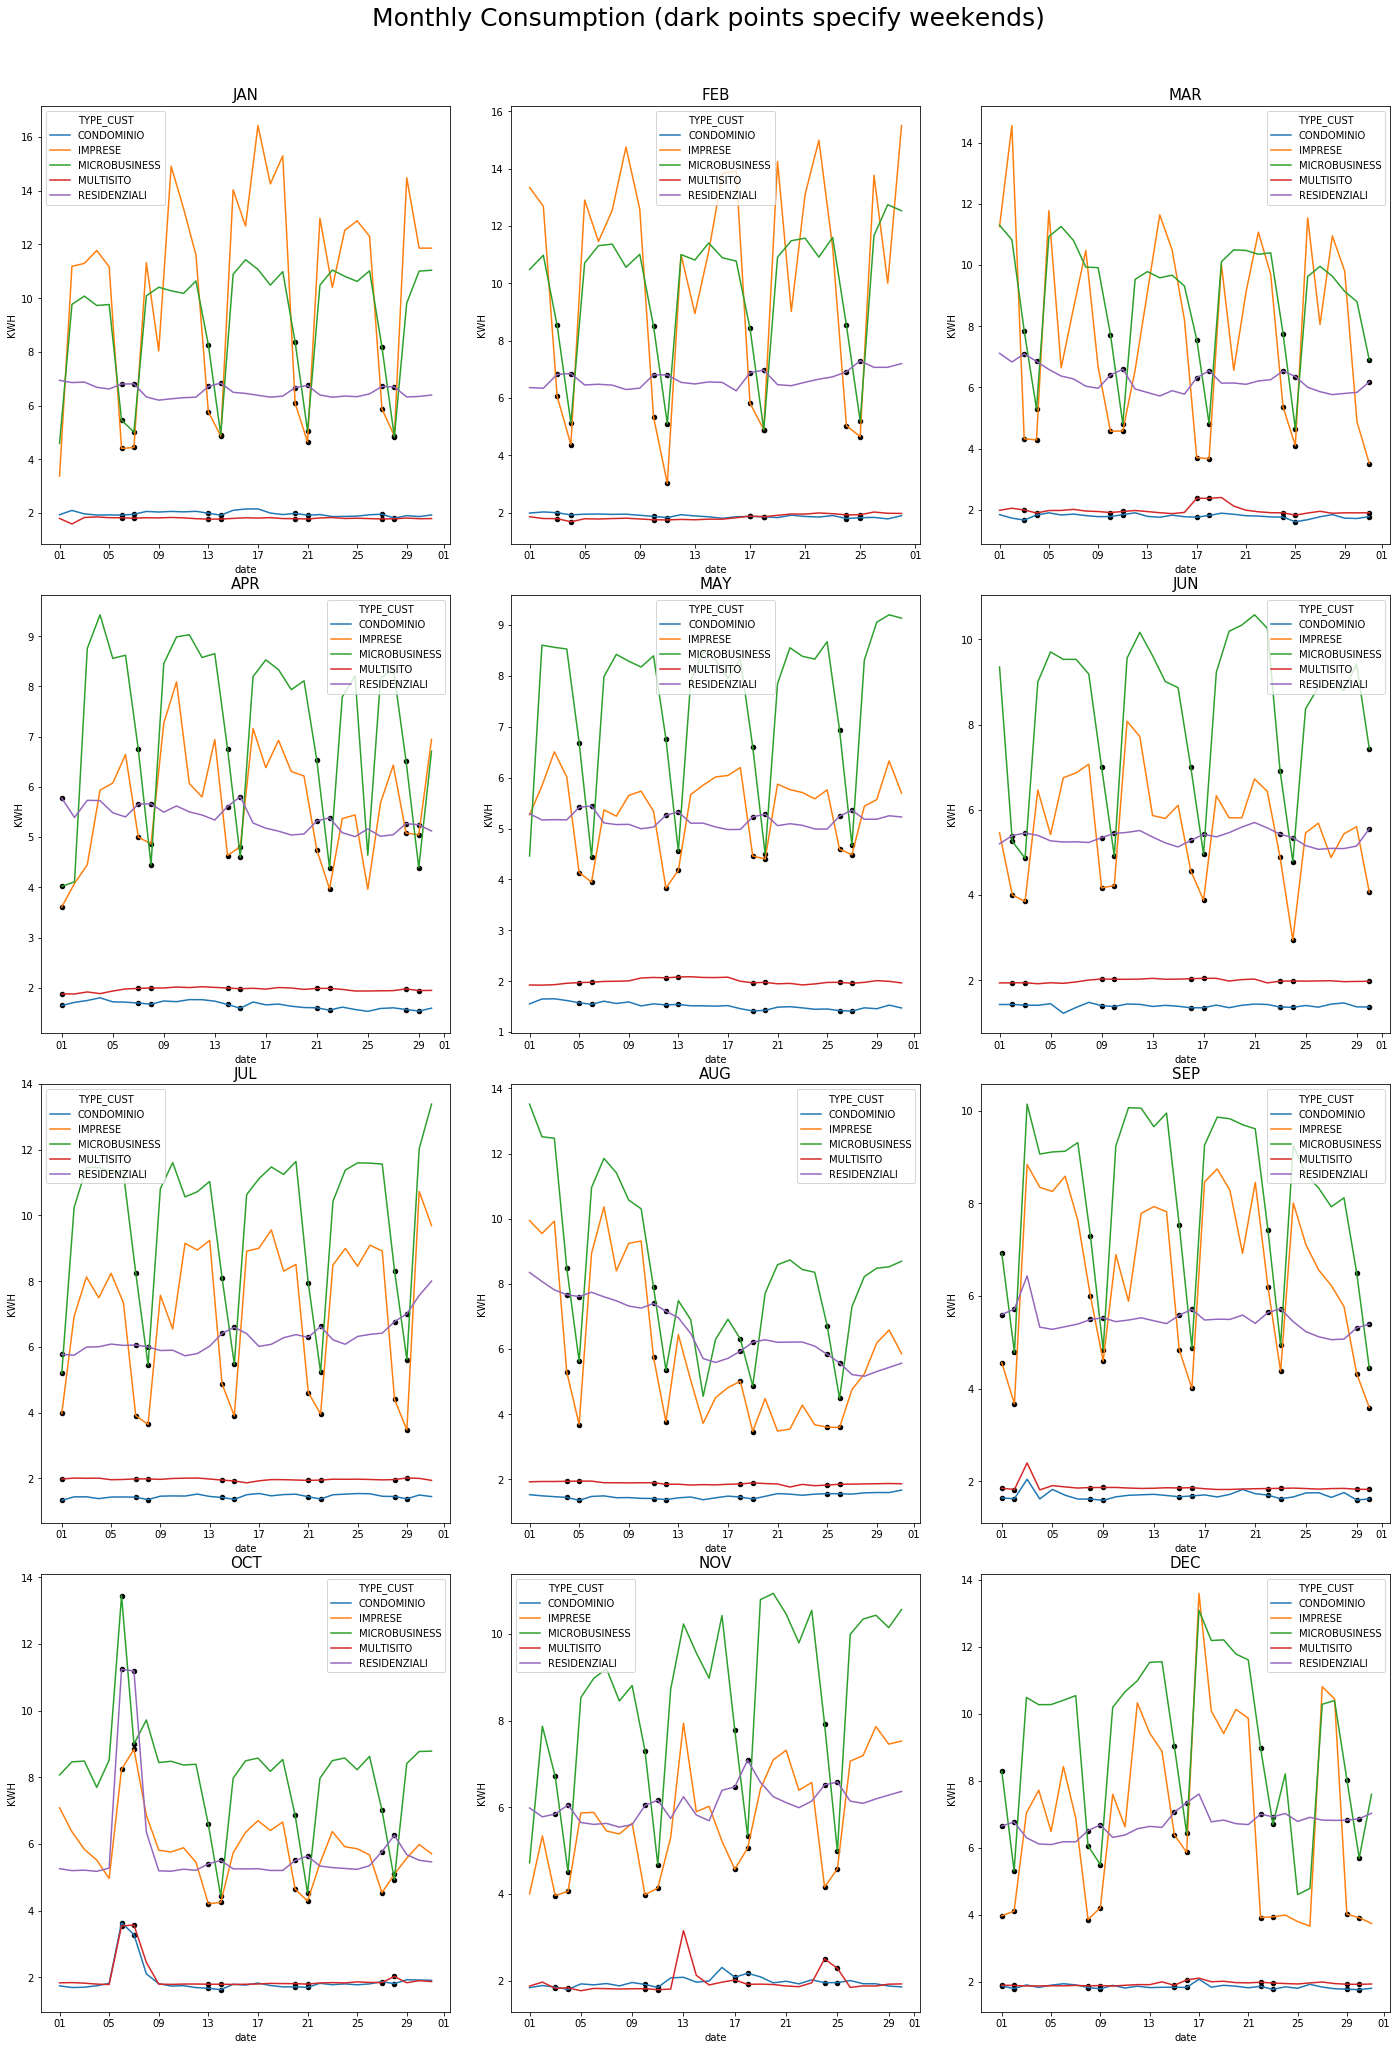

In [20]:
fig, ax = plt.subplots(nrows = 4, ncols = 3, figsize = (20, 30))
fig.tight_layout(rect=[0, 0.03, 1, 0.95], pad = 3)
fig.suptitle("Monthly Consumption (dark points specify weekends)", fontsize = 25, weight = 25)
for month, sub_df in data_time_series_TYPE_CUST.groupby("month"):
    ax_temp = ax[(month - 1) // 3, (month - 1) % 3]
    ax_temp.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
    ax_temp.set_title(months[month - 1].upper(), fontdict = {"fontsize": "15", "fontweight" : "15"})
    sns.lineplot(data = sub_df, x = "date", y = "KWH", hue = "TYPE_CUST", ax = ax_temp)
    ax_temp.scatter(data = sub_df[ sub_df["weekday"] == False ], x = "date", y = "KWH", c = "black", s = 20)
plt.savefig("MonthlyConsumptionPlot.png", dpi = 500)

### But if you see the average... Problem?

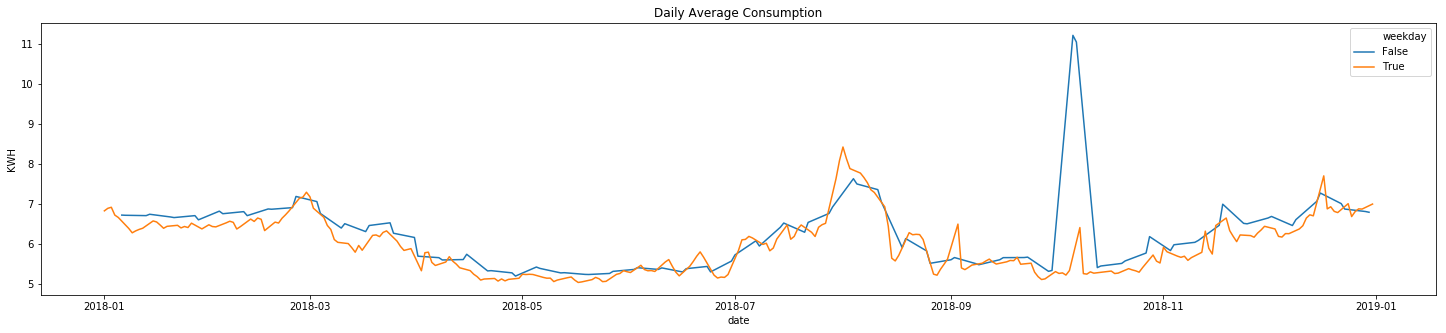

In [21]:
data_time_series = test_train_long.groupby("date").mean().reset_index()
fig, ax = plt.subplots(figsize = (25, 5))
ax.set_title("Daily Average Consumption")
sns.lineplot(data = data_time_series, x = "date", y = "KWH", hue = "weekday", ax = ax)
plt.savefig("line.png", quality = 100)

In [22]:
cat_var_train = train_raw.iloc[:, last_day_idx + 2: ].drop("AGE_CUST", axis = 1)
cat_var_train.head()

,TYPE_CUST,GENDER,BILLING,PAYMENT,TYPE_OFFER,FAMILY_OFFER,CAP,CITY,PROVINCE,REGION,ALTIMETRIC_ZONE,CLIMATE_ZONE
0,RESIDENZIALI,F,BIMESTRALE,BOLLETTINO POSTALE,Semi all-in,Easy,28021,BORGOMANERO,NO,PIEMONTE,Collina Interna,E
1,RESIDENZIALI,F,BIMESTRALE,BOLLETTINO POSTALE,Prezzo fisso,Fixa,56038,PONSACCO,PI,TOSCANA,Pianura,D
2,RESIDENZIALI,NaN,BIMESTRALE,BOLLETTINO POSTALE,Prezzo fisso,Fixa,84014,NOCERA INFERIORE,SA,CAMPANIA,Pianura,C
3,RESIDENZIALI,M,MENSILE,DOMICILIAZIONE,Prezzo fisso,Link,40138,BOLOGNA,BO,EMILIA ROMAGNA,Collina Interna,E
4,RESIDENZIALI,NaN,BIMESTRALE,DOMICILIAZIONE,Prezzo fisso,Fixa,84014,NOCERA INFERIORE,SA,CAMPANIA,Pianura,C


In [23]:
cat_var_test = test_raw.iloc[:, last_day_idx + 1: ].drop("AGE_CUST", axis = 1)
cat_var_test.head()

,TYPE_CUST,GENDER,BILLING,PAYMENT,TYPE_OFFER,FAMILY_OFFER,CAP,CITY,PROVINCE,REGION,ALTIMETRIC_ZONE,CLIMATE_ZONE
0,RESIDENZIALI,F,BIMESTRALE,BOLLETTINO POSTALE,Prezzo fisso,Fixa,89030,SAN LUCA,RC,CALABRIA,Montagna Litoranea,C
1,RESIDENZIALI,M,BIMESTRALE,BOLLETTINO POSTALE,Prezzo fisso,Fixa,84014,NOCERA INFERIORE,SA,CAMPANIA,Pianura,C
2,RESIDENZIALI,F,BIMESTRALE,DOMICILIAZIONE,Prezzo fisso,Fixa,98057,MILAZZO,ME,SICILIA,Collina Litoranea,B
3,RESIDENZIALI,NaN,BIMESTRALE,BOLLETTINO POSTALE,Prezzo fisso,Fixa,55,LADISPOLI,RM,LAZIO,Collina Litoranea,C
4,RESIDENZIALI,F,BIMESTRALE,DOMICILIAZIONE,Prezzo fisso,Fixa,98057,MILAZZO,ME,SICILIA,Collina Litoranea,B


In [24]:
def prepare_cat_plot(cat, train_df, test_df):
    from plotnine import ggplot
    import matplotlib.pyplot as plt
    import pandas as pd
    
    cat_df = pd.DataFrame({"train": train_df[cat].value_counts(dropna = False), "test": test_df[cat].value_counts(dropna = False)})
    cat_long_df = pd.melt(cat_df.reset_index(), id_vars = "index")
    cat_long_df["cat"] = cat
    return cat_long_df.rename({"index": "value", "variable": "train_test", "value": "counts"}, axis = 1)

In [25]:
cat_plot_df = pd.DataFrame({"value": [], "train_test": [], "counts": [], "cat": []})
for cat in cat_var_train.columns:
    cat_plot_df = cat_plot_df.append(prepare_cat_plot(cat, cat_var_train, cat_var_test))

In [26]:
cat_plot_df_without_na = cat_plot_df.dropna(subset = ["counts"])

In [27]:
cat_plot_df_without_na.groupby(["train_test", "cat"])[["value"]].nunique(dropna = False).unstack()

value                                                     \
cat        ALTIMETRIC_ZONE BILLING  CAP CITY CLIMATE_ZONE FAMILY_OFFER GENDER   
train_test                                                                      
test                     5       2  199  188            5           23      3   
train                    5       3  224  212            5           24      3   

                                                         
cat        PAYMENT PROVINCE REGION TYPE_CUST TYPE_OFFER  
train_test                                               
test             3       44     14         6          8  
train            3       45     14         6          7

In [28]:
cat_plot_df_without_na.groupby(["cat"])[["value"]].nunique(dropna = False).T

cat,ALTIMETRIC_ZONE,BILLING,CAP,CITY,CLIMATE_ZONE,FAMILY_OFFER,GENDER,PAYMENT,PROVINCE,REGION,TYPE_CUST,TYPE_OFFER
value,5,3,252,231,5,26,3,3,49,15,6,8


* Levels that appear in test set but not training set are in theory impossible to predict. 
* Levels that appear in training but not in test should be kept only if there are enough observations to be worthy of estimating an extra dummy.
* nan is the same as above.

In [29]:
cat_train_dict = {name: set(df["value"]) for name, df in cat_plot_df_without_na[ cat_plot_df_without_na["train_test"] == "train" ].groupby("cat")}
cat_test_dict = {name: set(df["value"]) for name, df in cat_plot_df_without_na[ cat_plot_df_without_na["train_test"] == "test" ].groupby("cat")}

In [30]:
train_diff_test_dict = {cat: cat_train_dict[cat].difference(cat_test_dict[cat]) for cat in cat_train_dict}
test_diff_train_dict = {cat: cat_test_dict[cat].difference(cat_train_dict[cat]) for cat in cat_train_dict}

In [31]:
train_diff_test_df = pd.DataFrame([ [cat, level] for cat in train_diff_test_dict for level in train_diff_test_dict[cat] ], columns = ["cat", "level"]).fillna("NaN").set_index(["cat", "level"])
test_diff_train_df = pd.DataFrame([ [cat, level] for cat in test_diff_train_dict for level in test_diff_train_dict[cat] ], columns = ["cat", "level"]).fillna("NaN").set_index(["cat", "level"])

In [32]:
temp_diff_train = cat_plot_df[ cat_plot_df["train_test"] == "train"]
temp_diff_train = temp_diff_train.fillna("NaN").set_index(["cat", "value"])
train_diff_test_df["count"] = [temp_diff_train.loc[idx, "counts"] for idx in train_diff_test_df.index]
train_diff_test_df.sort_values(by = "count", ascending = False).to_csv("./data/train_diff_test.csv")

In [33]:
temp_diff_test = cat_plot_df[ cat_plot_df["train_test"] == "test"]
temp_diff_test = temp_diff_test.fillna("NaN").set_index(["cat", "value"])
test_diff_train_df["count"] = [temp_diff_test.loc[idx, "counts"] for idx in test_diff_train_df.index]
test_diff_train_df.sort_values(by = "count", ascending = False).to_csv("./data/test_diff_train.csv")

/usr/lib/python3.7/site-packages/plotnine/layer.py:430: UserWarning: position_stack : Removed 1 rows containing missing values.
  data = self.position.setup_data(self.data, params)
/usr/lib/python3.7/site-packages/plotnine/layer.py:430: UserWarning: position_stack : Removed 1 rows containing missing values.
  data = self.position.setup_data(self.data, params)
/usr/lib/python3.7/site-packages/plotnine/layer.py:430: UserWarning: position_stack : Removed 5 rows containing missing values.
  data = self.position.setup_data(self.data, params)
/usr/lib/python3.7/site-packages/plotnine/layer.py:430: UserWarning: position_stack : Removed 81 rows containing missing values.
  data = self.position.setup_data(self.data, params)
/usr/lib/python3.7/site-packages/plotnine/layer.py:430: UserWarning: position_stack : Removed 62 rows containing missing values.
  data = self.position.setup_data(self.data, params)
/usr/lib/python3.7/site-packages/plotnine/layer.py:430: UserWarning: position_stack : Removed

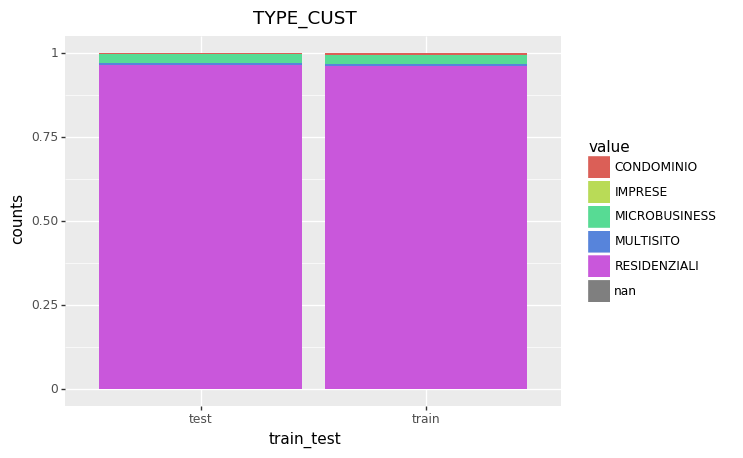

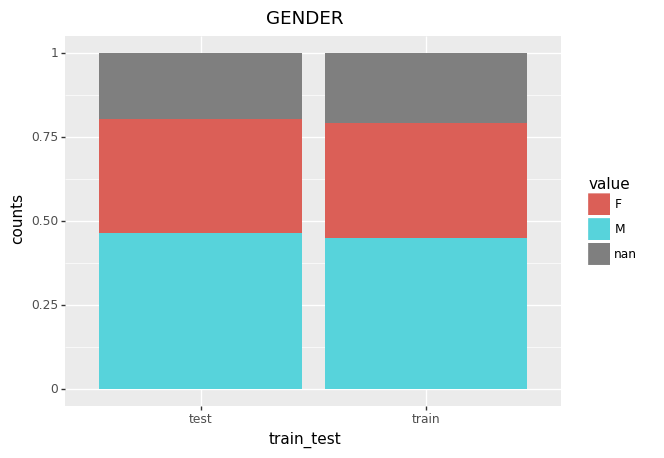

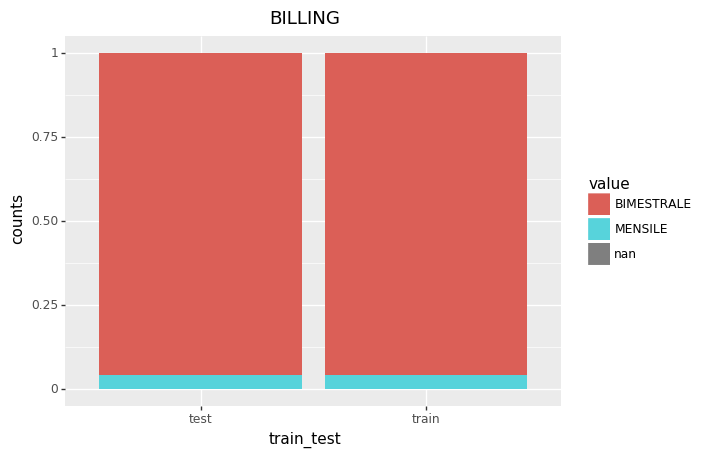

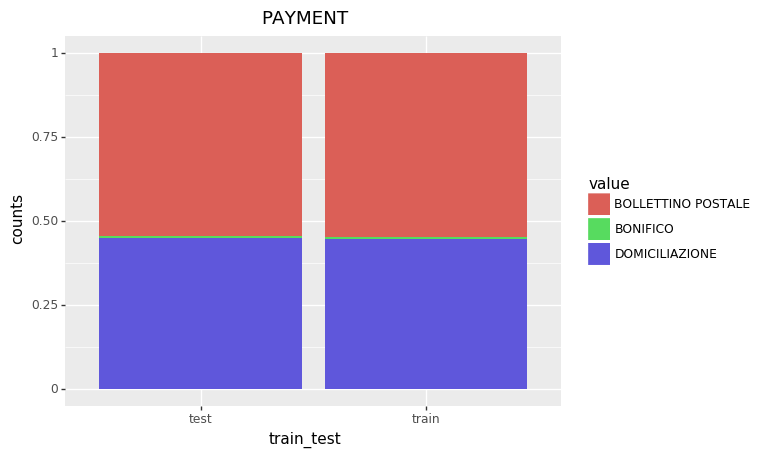

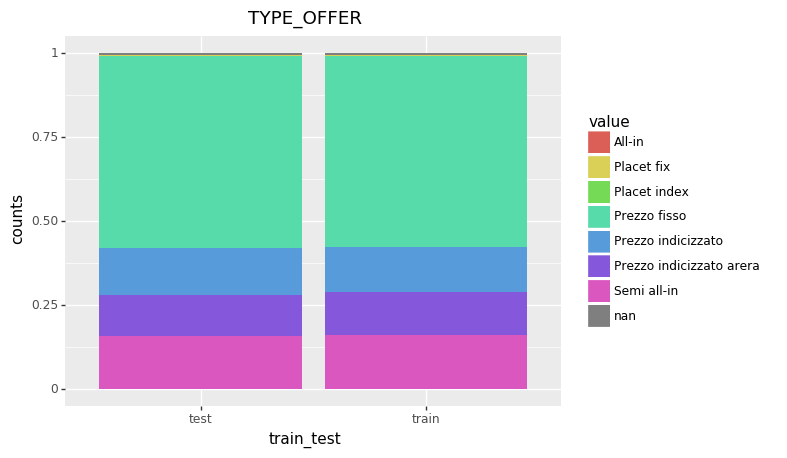

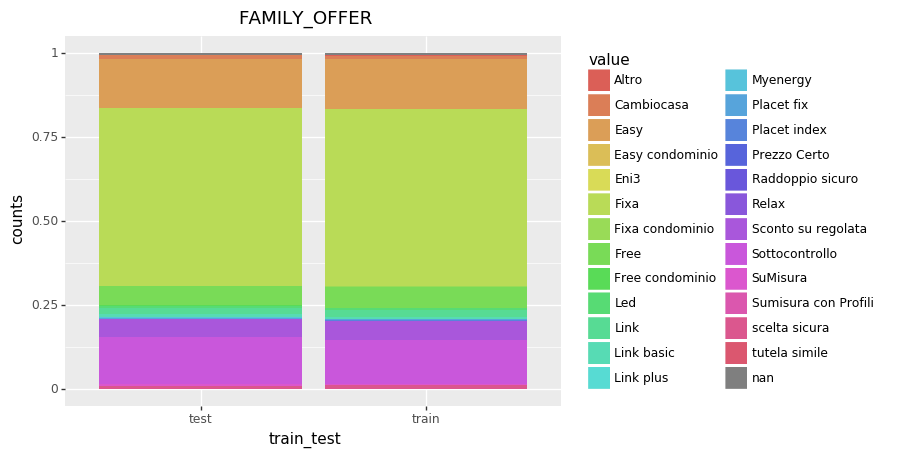

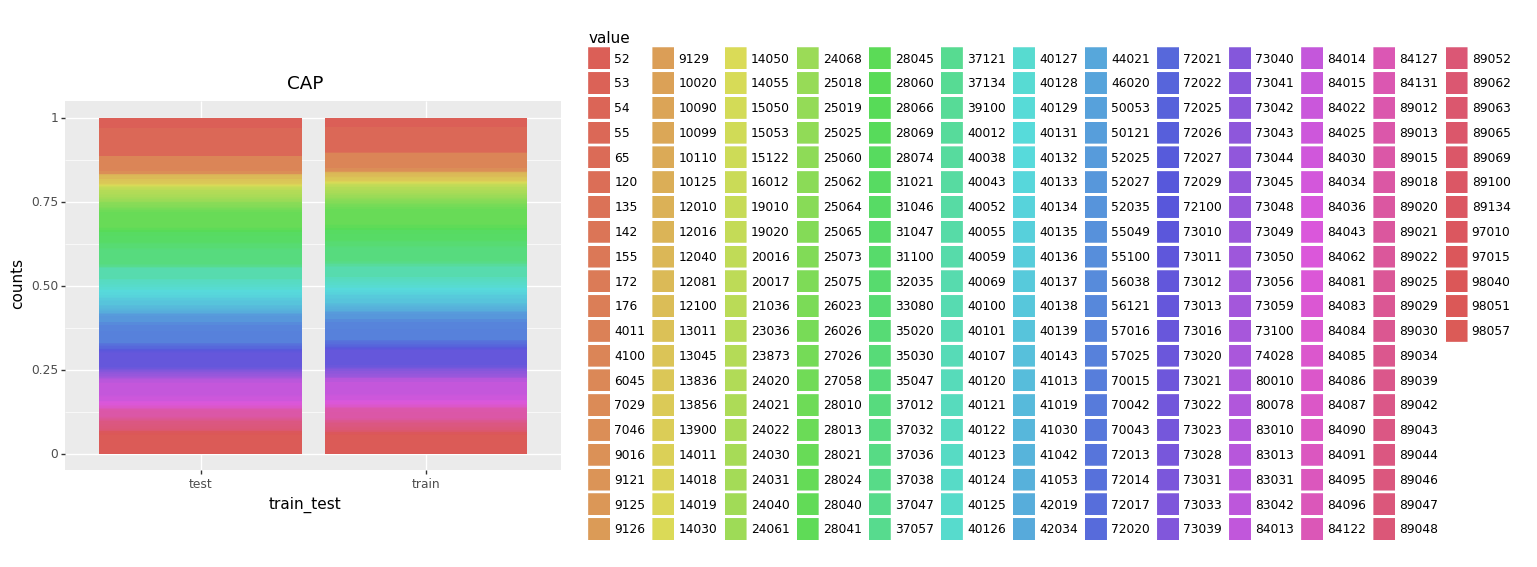

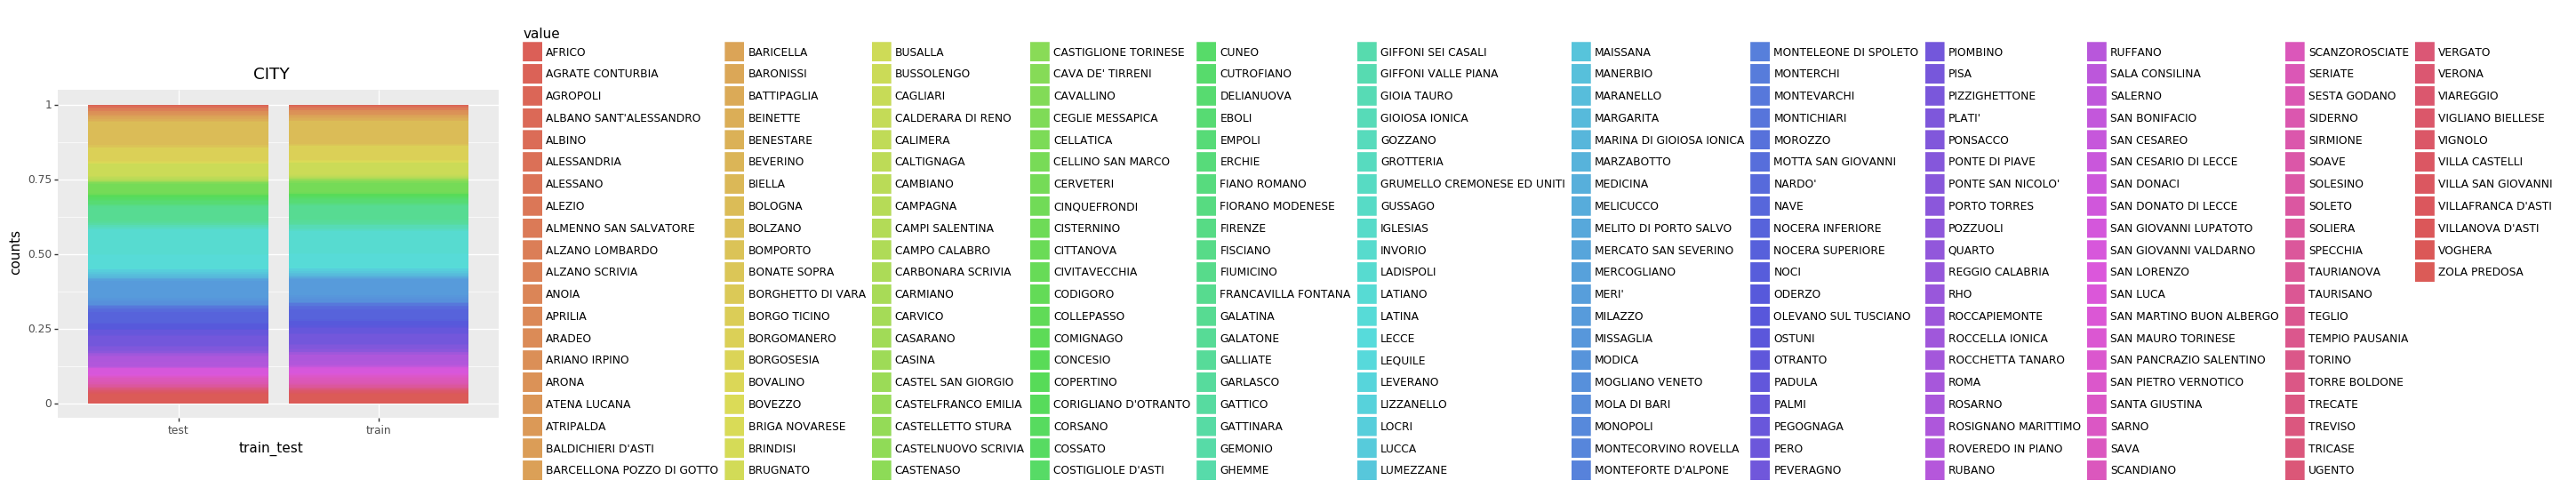

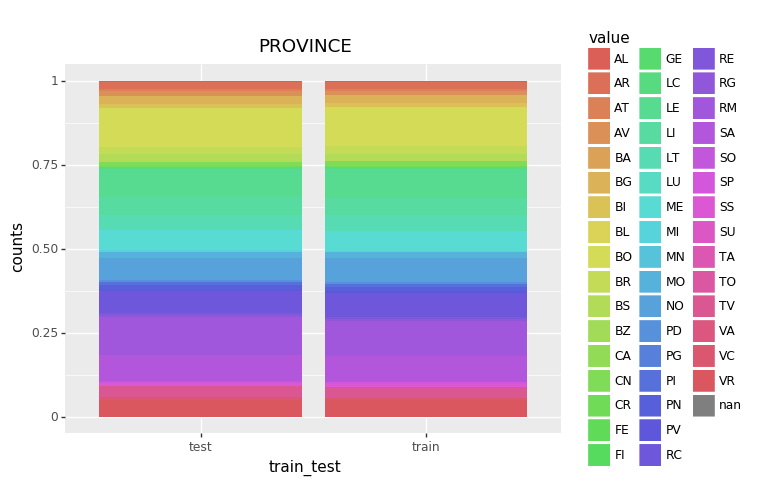

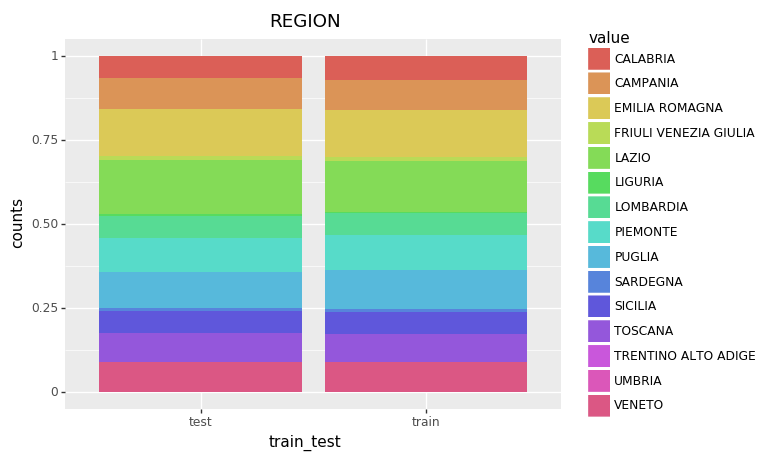

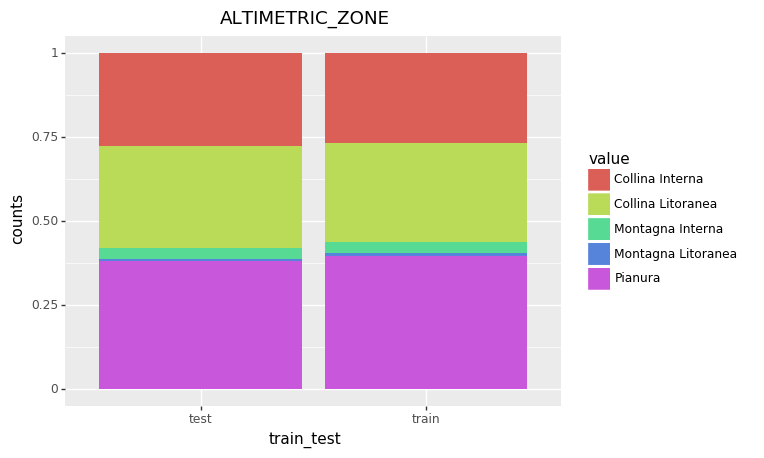

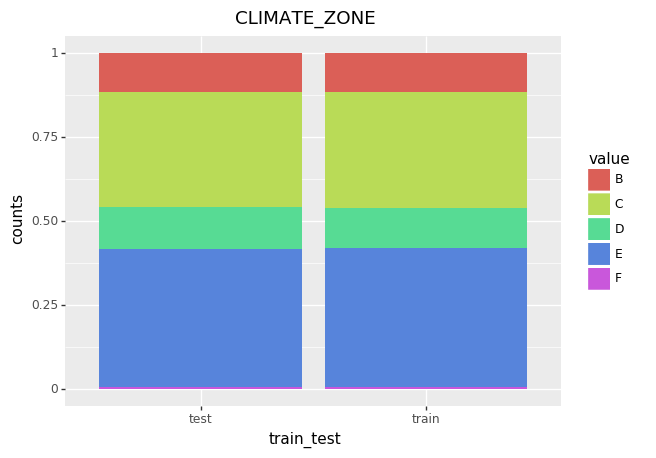

In [34]:
for cat in cat_plot_df["cat"].unique():
    (ggplot(cat_plot_df[cat_plot_df["cat"] == cat], aes(x = "train_test", y='counts', fill= "value"))
     + geom_col(position = "fill") + ggtitle(cat)
    ).draw()
#     .save("./plot/cat_plot/" + cat + ".png")

# Impute Missing Data

### Impute Consumption

In [125]:
train_new = train_raw.copy()
test_new = test_raw.copy()

In [126]:
train_consump_long = pd.melt(train_new.loc[:, "X1jan2018": "X31dec2018"].reset_index(), id_vars = "index", var_name = "date", value_name = "KWH")
train_consump_long["date"] = pd.to_datetime(train_consump_long["date"], format = 'X%d%b%Y')
train_consump_long["weekday"] = train_consump_long["date"].apply(lambda date: date.weekday() in range(5))
train_consump_long["week"] = train_consump_long["date"].dt.week
train_consump_long["month"] = train_consump_long["date"].dt.month
train_consump_long.head()

,index,date,KWH,weekday,week,month
0,0,2018-01-01,5.974,True,1,1
1,1,2018-01-01,3.536,True,1,1
2,2,2018-01-01,0.000,True,1,1
3,3,2018-01-01,6.917,True,1,1
4,4,2018-01-01,0.880,True,1,1


In [127]:
consump_target_week = train_consump_long.groupby(["index", "weekday", "week"])["KWH"].mean()
consump_target_month = train_consump_long.groupby(["index", "weekday", "month"])["KWH"].mean()
train_consump_long_without_na = train_consump_long\
                                .merge(consump_target_week, left_on = ["index", "weekday", "week"], right_index = True, how = "left", suffixes = ["", "_infer_week"]) \
                                .merge(consump_target_month, left_on = ["index", "weekday", "month"], right_index = True, how = "left", suffixes = ["", "_infer_month"]) \
                                [ ["index", "date", "weekday", "week", "KWH", "KWH_infer_week", "KWH_infer_month"] ] 
train_consump_long_without_na.loc[train_consump_long_without_na["KWH"].isna(), "KWH"] = train_consump_long_without_na.loc[train_consump_long_without_na["KWH"].isna(), "KWH_infer_week"]
train_consump_long_without_na.loc[train_consump_long_without_na["KWH"].isna(), "KWH"] = train_consump_long_without_na.loc[train_consump_long_without_na["KWH"].isna(), "KWH_infer_month"]

In [128]:
train_consump_wide = pd.pivot(train_consump_long_without_na[ ["index", "date", "KWH"] ], index = "index", columns = "date").reset_index(drop = True)
train_consump_wide.columns = [str(column[1].day) + "/" + str(column[1].month) + "/2018" for column in train_consump_wide.columns]
train_new = train_new.join(train_consump_wide.dropna(), how = "right")
train_new = pd.concat([train_new["y"], train_new.iloc[:, 366:]], axis = 1)

In [129]:
test_consump_long = pd.melt(test_new.loc[:, "X1jan2018": "X31dec2018"].reset_index(), id_vars = "index", var_name = "date", value_name = "KWH")
test_consump_long["date"] = pd.to_datetime(test_consump_long["date"], format = 'X%d%b%Y')
test_consump_long["weekday"] = test_consump_long["date"].apply(lambda date: date.weekday() in range(5))
test_consump_long["week"] = test_consump_long["date"].dt.week
test_consump_long["month"] = test_consump_long["date"].dt.month
test_consump_long.head()

,index,date,KWH,weekday,week,month
0,0,2018-01-01,4.535,True,1,1
1,1,2018-01-01,9.396,True,1,1
2,2,2018-01-01,7.804,True,1,1
3,3,2018-01-01,13.991,True,1,1
4,4,2018-01-01,7.750,True,1,1


In [130]:
consump_target_week = test_consump_long.groupby(["index", "weekday", "week"])["KWH"].mean()
consump_target_month = test_consump_long.groupby(["index", "weekday", "month"])["KWH"].mean()
test_consump_long_without_na = test_consump_long\
                                .merge(consump_target_week, left_on = ["index", "weekday", "week"], right_index = True, how = "left", suffixes = ["", "_infer_week"]) \
                                .merge(consump_target_month, left_on = ["index", "weekday", "month"], right_index = True, how = "left", suffixes = ["", "_infer_month"]) \
                                [ ["index", "date", "weekday", "week", "KWH", "KWH_infer_week", "KWH_infer_month"] ] 
test_consump_long_without_na.loc[test_consump_long_without_na["KWH"].isna(), "KWH"] = test_consump_long_without_na.loc[test_consump_long_without_na["KWH"].isna(), "KWH_infer_week"]
test_consump_long_without_na.loc[test_consump_long_without_na["KWH"].isna(), "KWH"] = test_consump_long_without_na.loc[test_consump_long_without_na["KWH"].isna(), "KWH_infer_month"]

In [131]:
test_consump_wide = pd.pivot(test_consump_long_without_na[ ["index", "date", "KWH"] ], index = "index", columns = "date").reset_index(drop = True)
test_consump_wide.columns = [str(column[1].day) + "/" + str(column[1].month) + "/2018" for column in test_consump_wide.columns]
test_new = test_new.join(test_consump_wide.dropna(), how = "right")
test_new = test_new.iloc[:, 365:]

In [132]:
train_new.shape

(10000, 379)

### Drop Irregular Observations

In [133]:
train_new.loc[train_new["TYPE_CUST"] == "IMPRESE", "1/1/2018":].loc[1660, :].shape[0]

365

In [134]:
y1 = train_new.loc[train_new["TYPE_CUST"] == "IMPRESE", "1/1/2018":].loc[1660, :]
y2 = train_new.loc[train_new["TYPE_CUST"] == "IMPRESE", "1/1/2018":].loc[3960, :]
y3 = train_new.loc[train_new["TYPE_CUST"] == "IMPRESE", "1/1/2018":].drop([1660, 3960]).mean()

In [135]:
c = pd.concat([y1, y2, y3], axis = 1)

In [136]:
c = c.rename({0: "others"}, axis = 1)
c.index = pd.date_range(start = "1/1/2018", end = "12/31/2018")

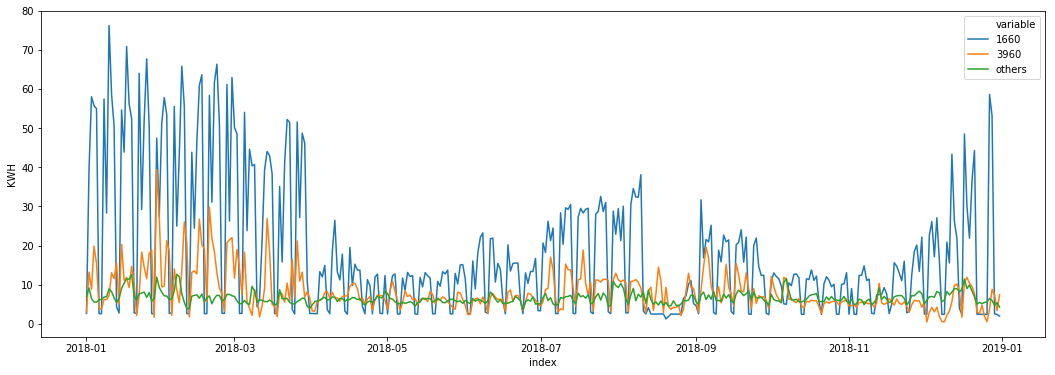

In [137]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (18,  6))
sns.lineplot(data = pd.melt(c.reset_index(), id_vars =  "index").rename({"value": "KWH"}, axis = 1), x = "index", y = "KWH", hue = "variable")
plt.savefig("irregular.png", quality = 100, dpi = 500)

In [138]:
train_new.loc[train_new["TYPE_CUST"] == "IMPRESE", "1/1/2018":]

,1/1/2018,2/1/2018,3/1/2018,4/1/2018,5/1/2018,6/1/2018,7/1/2018,8/1/2018,9/1/2018,10/1/2018,...,22/12/2018,23/12/2018,24/12/2018,25/12/2018,26/12/2018,27/12/2018,28/12/2018,29/12/2018,30/12/2018,31/12/2018
388,16.072,24.722,11.857,9.841,8.819,7.404,7.551,12.100,10.113,22.853,...,5.650,5.537,5.842,5.774,5.772,13.871,11.303,4.611,4.633,4.467
419,0.947,0.916,0.926,0.917,0.942,0.939,0.935,1.450,3.103,1.634,...,1.023,1.000,0.980,0.998,1.003,1.129,0.987,0.997,0.990,1.007
1660,2.632,39.167,58.016,55.763,54.967,2.595,2.591,57.454,28.299,76.240,...,2.431,2.430,2.411,2.420,2.403,58.620,53.187,2.550,2.402,1.952
3379,16.026,18.188,17.624,15.278,16.074,20.601,20.830,16.198,17.554,17.566,...,15.337,17.676,16.021,17.638,17.590,14.325,14.338,15.264,18.302,12.966
3563,1.677,1.704,1.625,1.550,1.600,1.554,1.547,4.144,3.640,2.424,...,2.118,2.138,2.068,2.115,2.260,2.292,2.093,2.075,2.012,2.044
3960,2.977,13.208,8.835,19.860,15.440,3.835,3.833,6.221,6.188,7.190,...,3.051,2.608,4.761,1.844,0.535,3.726,8.813,7.330,3.373,7.410
8127,0.223,0.228,0.224,0.228,0.221,0.222,0.222,0.226,0.228,0.228,...,1.084,1.077,0.845,0.908,0.853,0.854,0.863,0.827,1.018,0.938


In [139]:
train_new.drop([1660, 3960], inplace = True)

### Impute Categorical Variables (Train_Diff_Test)

* PROVINCE

In [140]:
train_diff_test_df.loc["PROVINCE"]

,count
level,
TA,2.0
BZ,1.0
FE,1.0
BA,3.0
SU,1.0


In [141]:
train_new = train_new.loc[~train_new["PROVINCE"].isin(train_diff_test_df.loc["PROVINCE"].index)]

* FAMILY_OFFER

In [142]:
train_diff_test_df.loc["FAMILY_OFFER"]

,count
level,
Easy condominio,1.0
Altro,3.0
Prezzo Certo,1.0


In [143]:
train_new = train_new.loc[~train_new["FAMILY_OFFER"].isin(train_diff_test_df.loc["FAMILY_OFFER"].index)]

* GENDER

In [144]:
train_new.loc[train_new["GENDER"].isna(), "GENDER"] = "U"

In [145]:
# train_new.drop("GENDER", axis = 1, inplace = True)

* AGE_CUST

In [146]:
train_new.drop("AGE_CUST", axis = 1, inplace = True)

* PROVINCE

In [147]:
train_new.loc[train_new["PROVINCE"].isna(), "PROVINCE"] = "NA"

### Impute Categorical Variables (Test_Diff_Train)

* PROVINCE

In [148]:
test_new.loc[test_new['PROVINCE'] == "VA", "PROVINCE"] = "MI"
test_new.loc[test_new['PROVINCE'] == "FI", "PROVINCE"] = "PI"
test_new.loc[test_new['PROVINCE'] == "LU", "PROVINCE"] = "PI"
test_new.loc[test_new['PROVINCE'] == "PG", "PROVINCE"] = "AR"
test_new.loc[test_new["PROVINCE"].isna(), "PROVINCE"] = "NA"

* GENDER

In [149]:
test_new.loc[test_new["GENDER"].isna(), "GENDER"] = "U"

In [150]:
# test_new.drop("GENDER", axis = 1, inplace = True)

* AGE_CUST

In [151]:
test_new.drop("AGE_CUST", axis = 1, inplace = True)

### Impute Categorical Variables (INFER)

In [152]:
train_new.loc[train_new["TYPE_OFFER"].isna(), "TYPE_OFFER"] = "MISSING"
train_new.loc[train_new["FAMILY_OFFER"].isna(), "FAMILY_OFFER"] = "MISSING"

In [153]:
test_new.loc[test_new["TYPE_OFFER"].isna(), "TYPE_OFFER"] = "MISSING"
test_new.loc[test_new["FAMILY_OFFER"].isna(), "FAMILY_OFFER"] = "MISSING"

In [154]:
train_new.isna().sum().sort_values(ascending = False).head()

TYPE_CUST     2
BILLING       2
31/12/2018    0
27/4/2018     0
18/4/2018     0
dtype: int64

In [155]:
train_new.dropna(inplace = True)
train_new.shape

(9981, 378)

In [156]:
train_test = pd.concat([train_new.iloc[:, 1:], test_new])

In [157]:
train_test.head()

,TYPE_CUST,GENDER,BILLING,PAYMENT,TYPE_OFFER,FAMILY_OFFER,CAP,CITY,PROVINCE,REGION,...,22/12/2018,23/12/2018,24/12/2018,25/12/2018,26/12/2018,27/12/2018,28/12/2018,29/12/2018,30/12/2018,31/12/2018
0,RESIDENZIALI,F,BIMESTRALE,BOLLETTINO POSTALE,Semi all-in,Easy,28021,BORGOMANERO,NO,PIEMONTE,...,6.886,6.115,8.126,5.202,5.222,6.610,11.452,8.203,4.618,7.066
1,RESIDENZIALI,F,BIMESTRALE,BOLLETTINO POSTALE,Prezzo fisso,Fixa,56038,PONSACCO,PI,TOSCANA,...,6.223,5.841,6.804,4.687,4.673,5.362,5.530,7.623,6.750,6.640
2,RESIDENZIALI,U,BIMESTRALE,BOLLETTINO POSTALE,Prezzo fisso,Fixa,84014,NOCERA INFERIORE,SA,CAMPANIA,...,11.663,12.614,15.620,10.565,10.543,13.805,17.230,18.044,13.343,12.007
3,RESIDENZIALI,M,MENSILE,DOMICILIAZIONE,Prezzo fisso,Link,40138,BOLOGNA,BO,EMILIA ROMAGNA,...,8.086,5.147,2.048,2.025,2.009,9.331,10.167,9.074,9.479,10.857
4,RESIDENZIALI,U,BIMESTRALE,DOMICILIAZIONE,Prezzo fisso,Fixa,84014,NOCERA INFERIORE,SA,CAMPANIA,...,0.046,0.061,0.064,0.045,0.047,0.032,0.046,0.048,0.064,0.051


In [158]:
def select_cat(cat, df, target, level = None):
    import pandas as pd
    import numpy as np
    
    if level is not None:
        print("DROP!")
        df = df[df[cat] != level]
    dist_dict = {}
    for name, series in pd.concat([df[cat], df.loc[:, "1/1/2018":]], axis = 1).groupby([cat]).mean().iterrows():
        dist_dict[name] = np.abs(np.array(series) - target).sum()
    dist_Series = pd.Series(dist_dict)
    return (dist_Series.sort_values().index[0], dist_Series.min())

In [159]:
(cat_allin, dist_allin) = select_cat("TYPE_OFFER", train_test, np.array(train_test.loc[train_test["TYPE_OFFER"] == "All-in", "1/1/2018":])[0], "All-in")
print(cat_allin, dist_allin)

DROP!
Placet fix 359.93527741935486


In [160]:
(cat_relax, dist_relax) = select_cat("FAMILY_OFFER", train_test, np.array(train_test.loc[train_test["FAMILY_OFFER"] == "Relax", "1/1/2018":])[0], "Relax")
print(cat_relax, dist_relax)

DROP!
Cambiocasa 291.3028120890937


In [161]:
(cat_sumi, dist_sumi) = select_cat("FAMILY_OFFER", train_test, np.array(train_test.loc[train_test["FAMILY_OFFER"] == "Sumisura con Profili", "1/1/2018":])[0], "Sumisura con Profili")
print(cat_relax, dist_relax)

DROP!
Cambiocasa 291.3028120890937


In [162]:
(cat_null, dist_null) = select_cat("TYPE_CUST", train_test, np.array(train_test.loc[train_test["TYPE_CUST"].isna(), "1/1/2018":])[0])
print(cat_null, dist_null)

IMPRESE 566.9600714285715


In [163]:
test_new.loc[test_new["FAMILY_OFFER"] == "Relax", "FAMILY_OFFER"] = cat_relax
test_new.loc[test_new["FAMILY_OFFER"] == "Sumisura con Profili", "FAMILY_OFFER"] = cat_sumi
test_new.loc[test_new["TYPE_CUST"].isna(), "TYPE_CUST"] = cat_null
test_new.loc[test_new["TYPE_OFFER"] == "All-in", "TYPE_OFFER"] = cat_allin

In [164]:
train_test = pd.concat([train_new.iloc[:, 1:], test_new])

# Final Check

In [165]:
for cat_column in train_new.loc[:, "TYPE_CUST": "CLIMATE_ZONE"].columns:
    print(cat_column, set(train_new[cat_column].unique()) == set(test_new[cat_column].unique()))

TYPE_CUST True
GENDER True
BILLING True
PAYMENT True
TYPE_OFFER True
FAMILY_OFFER True
CAP False
CITY False
PROVINCE True
REGION False
ALTIMETRIC_ZONE True
CLIMATE_ZONE True


In [166]:
train_new.isna().sum().sum()

0

In [261]:
test_new.isna().sum().sum()

0

# Laaso_new

In [287]:
train_new_lasso = train_new.drop(["CAP", "CITY", "PROVINCE"], axis = 1)
test_new_lasso = test_new.drop(["CAP", "CITY", "PROVINCE"], axis = 1)

In [288]:
train_X, train_y = pd.get_dummies(train_new_lasso, drop_first = True).iloc[:, 1:], pd.get_dummies(train_new_lasso, drop_first = True).iloc[:, 0]

In [299]:
(test_new_lasso["REGION"] == "UMBIRA").sum()

0

In [307]:
test_new_lasso.loc[test_new_lasso["REGION"] == "UMBIRA", "REGION"] = "CAMPANIA"

In [308]:
test_X = pd.get_dummies(test_new_lasso, drop_first = True)

In [291]:
from sklearn.linear_model import LassoCV

In [314]:
reg = LassoCV(cv = 10, normalize = True, max_iter = 10000, n_jobs = -1, alphas =  np.linspace(0.00025, 0.00035, 10000), fit_intercept = True)

In [315]:
reg.fit(train_X, train_y)

LassoCV(alphas=array([0.00025, 0.00025, ..., 0.00035, 0.00035]), copy_X=True,
    cv=10, eps=0.001, fit_intercept=True, max_iter=10000, n_alphas=100,
    n_jobs=-1, normalize=True, positive=False, precompute='auto',
    random_state=None, selection='cyclic', tol=0.0001, verbose=False)

In [313]:
reg.alpha_

AttributeError: 'LassoCV' object has no attribute 'alpha_'

In [305]:
train_X.shape

(9981, 420)

In [306]:
set(test_X.columns).difference(train_X.columns)

{'REGION_UMBRIA'}

In [317]:
pd.Series(reg.predict(test_X.drop("REGION_UMBRIA", axis = 1))).to_csv("newnew2.txt", header = False, index = False)

In [191]:
result_lasso = reg.predict(test_X)
result_lasso = pd.Series(result_lasso)
result_lasso = result_lasso.apply(lambda row: max(row, 0))

In [192]:
result_lasso.to_csv("newnew.txt", header = False, index = False)

In [200]:
test_X.shape

(4810, 447)

In [217]:
test_X.columns[reg.coef_!=0].tolist()[:98]

['1/1/2018',
 '2/1/2018',
 '3/1/2018',
 '5/1/2018',
 '6/1/2018',
 '7/1/2018',
 '13/1/2018',
 '19/1/2018',
 '22/1/2018',
 '24/1/2018',
 '27/1/2018',
 '10/2/2018',
 '16/2/2018',
 '17/2/2018',
 '24/2/2018',
 '25/2/2018',
 '27/2/2018',
 '1/3/2018',
 '2/3/2018',
 '5/3/2018',
 '7/3/2018',
 '10/3/2018',
 '13/3/2018',
 '16/3/2018',
 '23/3/2018',
 '24/3/2018',
 '25/3/2018',
 '27/3/2018',
 '29/3/2018',
 '31/3/2018',
 '1/4/2018',
 '7/4/2018',
 '13/4/2018',
 '23/4/2018',
 '25/4/2018',
 '29/4/2018',
 '1/5/2018',
 '11/5/2018',
 '16/5/2018',
 '21/5/2018',
 '27/5/2018',
 '31/5/2018',
 '1/6/2018',
 '10/6/2018',
 '25/6/2018',
 '27/6/2018',
 '28/6/2018',
 '29/6/2018',
 '2/7/2018',
 '3/7/2018',
 '7/7/2018',
 '14/7/2018',
 '18/7/2018',
 '3/8/2018',
 '11/8/2018',
 '2/9/2018',
 '8/9/2018',
 '15/9/2018',
 '22/9/2018',
 '27/9/2018',
 '2/10/2018',
 '3/10/2018',
 '6/10/2018',
 '8/10/2018',
 '9/10/2018',
 '16/10/2018',
 '27/10/2018',
 '30/10/2018',
 '31/10/2018',
 '1/11/2018',
 '4/11/2018',
 '10/11/2018',
 '12/11

In [218]:
temp = test_X.columns[reg.coef_!=0].tolist()[:98]

In [223]:
temp = pd.to_datetime(temp, format = "%d/%m/%Y")
temp = pd.Series(temp)

In [230]:
mask = reg.coef_!=0

In [236]:
c = reg.coef_[reg.coef_!=0][:98]

In [242]:
d = test_X.columns[reg.coef_!=0][:98]

In [251]:
a = pd.concat([pd.Series(d), pd.Series(c)], axis =1)

In [260]:
a.groupby("weekday").count()

,0,1
weekday,,
0,12,12
1,13,13
2,14,14
3,8,8
4,13,13
5,25,25
6,13,13


In [258]:
a.groupby("weekday").sum()

,1
weekday,
0,-0.046345
1,-0.043515
2,0.048271
3,0.017907
4,0.049597
5,0.836061
6,0.138749


# Lasso

In [118]:
train_new_lasso = train_new.drop(["CAP", "CITY", "REGION"], axis = 1)
test_new_lasso = test_new.drop(["CAP", "CITY", "REGION"], axis = 1)

In [119]:
train_X, train_y = pd.get_dummies(train_new_lasso, drop_first = True).iloc[:, 1:], pd.get_dummies(train_new_lasso, drop_first = True).iloc[:, 0]

In [120]:
test_X = pd.get_dummies(test_new_lasso, drop_first = True)

In [121]:
from sklearn.linear_model import LassoCV

In [123]:
reg = LassoCV(cv = 10, normalize = True, max_iter = 10000, n_jobs = -1, alphas =  np.linspace(0.00025, 0.00035, 10000), fit_intercept = True)

In [124]:
reg.fit(train_X, train_y)

LassoCV(alphas=array([0.00025, 0.00025, ..., 0.00035, 0.00035]), copy_X=True,
    cv=10, eps=0.001, fit_intercept=True, max_iter=10000, n_alphas=100,
    n_jobs=-1, normalize=True, positive=False, precompute='auto',
    random_state=None, selection='cyclic', tol=0.0001, verbose=False)

In [126]:
result_lasso = reg.predict(test_X)

In [130]:
train_X.shape

(9981, 445)

In [129]:
reg.coef_.shape

(445,)

In [125]:
reg.alpha_

0.0002783928392839284

In [127]:
(reg.coef_ != 0).sum()

121

In [101]:
np.savetxt("result_lasso_newest" + str(reg.alpha_) + ".txt", result_lasso, fmt = "%10.20f")

In [122]:
train_X.shape

(9981, 445)

In [109]:
train_X.columns[reg.coef_ !=0]

Index(['1/1/2018', '2/1/2018', '3/1/2018', '5/1/2018', '6/1/2018', '7/1/2018',
       '13/1/2018', '19/1/2018', '22/1/2018', '24/1/2018',
       ...
       'PROVINCE_NA', 'PROVINCE_RC', 'PROVINCE_RE', 'PROVINCE_SP',
       'PROVINCE_SS', 'PROVINCE_TO', 'ALTIMETRIC_ZONE_Montagna Interna',
       'ALTIMETRIC_ZONE_Montagna Litoranea', 'ALTIMETRIC_ZONE_Pianura',
       'CLIMATE_ZONE_E'],
      dtype='object', length=121)

In [140]:
train_X_selected = train_X.loc[:, train_X.columns[reg.coef_!=0].tolist()]
test_X_selected = test_X.loc[:, train_X.columns[reg.coef_!=0].tolist()]

In [147]:
train_X_selected.to_csv("./data/train_X_selected.csv", index = False)
test_X_selected.to_csv("./data/test_X_selected.csv", index = False)
train_y.to_csv("./data/y.csv", index = False)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


# RandomForest

In [1]:
train_X_selected = train_X.loc[:, features]

NameError: name 'train_X' is not defined

In [2]:
test_X_selected = test_X.loc[:, features]

NameError: name 'test_X' is not defined

In [87]:
train_X_selected.to_csv("./data/train_X_selected.csv")
test_X_selected.to_csv("./data/test_X_selected.csv")

In [216]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor

In [223]:
parameters = {"max_features" : "sqrt", "max_leaf_nodes": 50}
rf = RandomForestRegressor(n_estimators = 100,
                               max_features = parameters["max_features"],
                               max_leaf_nodes = parameters["max_leaf_nodes"],
                            n_jobs = -1)
rfcv = RFECV(rf, n_jobs = -1, cv = 5, scoring = "neg_mean_squared_error")
rfcv.fit(train_X_selected, train_y)

RFECV(cv=5,
   estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=50,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
   min_features_to_select=1, n_jobs=-1, scoring='neg_mean_squared_error',
   step=1, verbose=0)

In [224]:
result_rf_laso = rfcv.predict(test_X_selected)

In [226]:
np.savetxt("result_rf_lasso" + "_" + str(parameters["max_features"]) + "_" + str(parameters["max_leaf_nodes"]) + ".txt", result_lasso_all, fmt = "%10.10f")

In [183]:
test_new.columns.tolist()[:12]

['TYPE_CUST',
 'BILLING',
 'PAYMENT',
 'TYPE_OFFER',
 'FAMILY_OFFER',
 'CAP',
 'CITY',
 'PROVINCE',
 'REGION',
 'ALTIMETRIC_ZONE',
 'CLIMATE_ZONE',
 '1/1/2018']

# LASSO (CAP)

In [142]:
train_new["CAP"] = train_new["CAP"].astype(str)
test_new["CAP"] = test_new["CAP"].astype(str)

In [144]:
train_X, train_y = pd.get_dummies(train_new.drop(["CITY","PROVINCE", "REGION"], axis = 1), drop_first = True).iloc[:, 1:], pd.get_dummies(train_new.drop(["CITY","PROVINCE", "REGION"], axis = 1), drop_first = True).iloc[:, 0]

In [149]:
test_X = pd.get_dummies(test_new.drop(["CITY","PROVINCE", "REGION"], axis = 1), drop_first = True)

In [141]:
test_X.columns[800:]

Index([], dtype='object')

In [151]:
test_X_diff_train_X = set(test_X.columns.unique()).difference(set(train_X.columns.unique()))

In [154]:
train_X_diff_test_X = set(train_X.columns.unique()).difference(set(test_X.columns.unique()))

In [153]:
test_X.drop(list(test_X_diff_train_X), axis = 1, inplace = True)

In [155]:
train_X.drop(list(train_X_diff_test_X), axis = 1, inplace = True)

In [156]:
train_X.shape

(9981, 576)

In [157]:
test_X.shape

(4810, 576)

In [158]:
from sklearn.linear_model import LassoCV

In [177]:
reg = LassoCV(cv = 10, normalize = True, n_jobs = -1, alphas =  np.linspace(.0003, .0007, 2000))

In [178]:
reg.fit(train_X, train_y)

LassoCV(alphas=array([0.0003, 0.0003, ..., 0.0007, 0.0007]), copy_X=True,
    cv=10, eps=0.001, fit_intercept=True, max_iter=1000, n_alphas=100,
    n_jobs=-1, normalize=True, positive=False, precompute='auto',
    random_state=None, selection='cyclic', tol=0.0001, verbose=False)

In [181]:
result_lasso_all = reg.predict(test_X)

In [180]:
reg.alpha_

0.0003340170085042521

In [182]:
np.savetxt("result_lasso_all" + str(reg.alpha_) + ".txt", result_lasso_all, fmt = "%10.10f")

In [148]:
set(test_new["CAP"].unique()).difference(set(train_new["CAP"].unique()))

{'10110',
 '10125',
 '120',
 '14019',
 '14050',
 '142',
 '155',
 '21036',
 '24030',
 '25019',
 '27058',
 '28040',
 '40100',
 '40120',
 '50053',
 '50121',
 '54',
 '55049',
 '55100',
 '6045',
 '7029',
 '83010',
 '84030',
 '84085',
 '84091',
 '84131',
 '9121',
 '98040'}

# LASS (CITY)

In [183]:
train_X, train_y = pd.get_dummies(train_new.drop(["CAP","PROVINCE", "REGION"], axis = 1), drop_first = True).iloc[:, 1:], pd.get_dummies(train_new.drop(["CITY","PROVINCE", "REGION"], axis = 1), drop_first = True).iloc[:, 0]

In [184]:
test_X = pd.get_dummies(test_new.drop(["CAP","PROVINCE", "REGION"], axis = 1), drop_first = True)

In [185]:
test_X_diff_train_X = set(test_X.columns.unique()).difference(set(train_X.columns.unique()))

In [186]:
train_X_diff_test_X = set(train_X.columns.unique()).difference(set(test_X.columns.unique()))

In [187]:
test_X.drop(list(test_X_diff_train_X), axis = 1, inplace = True)

In [188]:
train_X.drop(list(train_X_diff_test_X), axis = 1, inplace = True)

In [189]:
train_X.shape

(9981, 574)

In [190]:
test_X.shape

(4810, 574)

In [191]:
from sklearn.linear_model import LassoCV

In [192]:
reg = LassoCV(cv = 10, normalize = True, n_jobs = -1, alphas =  np.linspace(.0003, .0007, 2000))

In [193]:
reg.fit(train_X, train_y)

LassoCV(alphas=array([0.0003, 0.0003, ..., 0.0007, 0.0007]), copy_X=True,
    cv=10, eps=0.001, fit_intercept=True, max_iter=1000, n_alphas=100,
    n_jobs=-1, normalize=True, positive=False, precompute='auto',
    random_state=None, selection='cyclic', tol=0.0001, verbose=False)

In [196]:
result_lasso_city = reg.predict(test_X)

In [200]:
reg.alpha_

0.0003260130065032516

In [201]:
np.savetxt("result_lasso_city" + str(reg.alpha_) + ".txt", result_lasso_city, fmt = "%10.10f")

In [ ]:
select_cat("CAP", train_test, np.array(test_new[test_new["CAP"] == 54].loc[:, "1/1/2018":]), 54)

# After_Model Plot

In [3]:
import pandas as pd
import numpy as np

In [3]:
from sklearn.svm import SVR

In [4]:
train_new = pd.read_csv("./data/train_new.csv", index_col = 0)
test_new = pd.read_csv("./data/test_new.csv", index_col = 0)
test_new.loc[test_new["PROVINCE"].isna(), "PROVINCE"] = "NA"
train_new.loc[train_new["PROVINCE"].isna(), "PROVINCE"] = "NA"
train_X_selected = pd.read_csv("./data/train_X_selected.csv", index_col = 0)
test_X_selected = pd.read_csv("./data/test_X_selected.csv", index_col = 9)

In [5]:
train_y = train_new.iloc[:, 0]

In [6]:
# train_new_lasso = train_new.drop(["CAP", "CITY", "REGION"], axis = 1)
# test_new_lasso = test_new.drop(["CAP", "CITY", "REGION"], axis = 1)

In [7]:
# train_X, train_y = pd.get_dummies(train_new_lasso, drop_first = True).iloc[:, 1:], pd.get_dummies(train_new_lasso, drop_first = True).iloc[:, 0]

In [8]:
# test_X = pd.get_dummies(test_new_lasso, drop_first = True)

In [ ]:
clf = SVR(kernel = "poly", C=1.0, epsilon=0.2)
clf.fit(train_X_selected, train_y)

/usr/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [ ]:
result_svm = clf.predict(test_X_selected)

In [48]:
result_svm

array([11.22931296,  8.48330455,  7.9893679 , ..., 13.14305857,
       13.14305857, 13.14305857])

In [49]:
np.savetxt("result_svm" + ".txt", result_svm, fmt = "%10.10f")

# Blue and Red

In [56]:
blue_month = [4, 5, 6, 9 ,10]

id_var = train_new.columns.tolist()[:12]

train_blue_red_long = pd.melt(train_new.reset_index(), id_vars = ["index"] + id_var, var_name = "date", value_name = "KWH")

train_blue_red_long["date"] = pd.to_datetime(train_blue_red_long["date"], format = "%d/%m/%Y")

train_blue_red_long_red = train_blue_red_long[~train_blue_red_long["date"].dt.month.isin(blue_month)]

train_blue_red_wide_red = pd.pivot_table(train_blue_red_long_red, index = ["index"] + id_var, columns = "date", values = "KWH").reset_index()

train_blue_red_wide_red.drop("index", inplace = True, axis = 1)

train_blue_red_wide_red.head()

date,y,TYPE_CUST,BILLING,PAYMENT,TYPE_OFFER,FAMILY_OFFER,CAP,CITY,PROVINCE,REGION,...,2018-12-22 00:00:00,2018-12-23 00:00:00,2018-12-24 00:00:00,2018-12-25 00:00:00,2018-12-26 00:00:00,2018-12-27 00:00:00,2018-12-28 00:00:00,2018-12-29 00:00:00,2018-12-30 00:00:00,2018-12-31 00:00:00
0,9.196,RESIDENZIALI,BIMESTRALE,BOLLETTINO POSTALE,Semi all-in,Easy,28021,BORGOMANERO,NO,PIEMONTE,...,6.886,6.115,8.126,5.202,5.222,6.610,11.452,8.203,4.618,7.066
1,8.718,RESIDENZIALI,BIMESTRALE,BOLLETTINO POSTALE,Prezzo fisso,Fixa,56038,PONSACCO,PI,TOSCANA,...,6.223,5.841,6.804,4.687,4.673,5.362,5.530,7.623,6.750,6.640
2,14.417,RESIDENZIALI,BIMESTRALE,BOLLETTINO POSTALE,Prezzo fisso,Fixa,84014,NOCERA INFERIORE,SA,CAMPANIA,...,11.663,12.614,15.620,10.565,10.543,13.805,17.230,18.044,13.343,12.007
3,10.738,RESIDENZIALI,MENSILE,DOMICILIAZIONE,Prezzo fisso,Link,40138,BOLOGNA,BO,EMILIA ROMAGNA,...,8.086,5.147,2.048,2.025,2.009,9.331,10.167,9.074,9.479,10.857
4,0.048,RESIDENZIALI,BIMESTRALE,DOMICILIAZIONE,Prezzo fisso,Fixa,84014,NOCERA INFERIORE,SA,CAMPANIA,...,0.046,0.061,0.064,0.045,0.047,0.032,0.046,0.048,0.064,0.051


In [60]:
id_var = test_new.columns.tolist()[:11]

test_blue_red_long = pd.melt(test_new.reset_index(), id_vars = ["index"] + id_var, var_name = "date", value_name = "KWH")

test_blue_red_long["date"] = pd.to_datetime(test_blue_red_long["date"], format = "%d/%m/%Y")

test_blue_red_long_red = test_blue_red_long[~test_blue_red_long["date"].dt.month.isin(blue_month)]

test_blue_red_wide_red = pd.pivot_table(test_blue_red_long_red, index = ["index"] + id_var, columns = "date", values = "KWH").reset_index()

test_blue_red_wide_red.drop("index", inplace = True, axis = 1)

test_blue_red_wide_red.head()

date,TYPE_CUST,BILLING,PAYMENT,TYPE_OFFER,FAMILY_OFFER,CAP,CITY,PROVINCE,REGION,ALTIMETRIC_ZONE,...,2018-12-22 00:00:00,2018-12-23 00:00:00,2018-12-24 00:00:00,2018-12-25 00:00:00,2018-12-26 00:00:00,2018-12-27 00:00:00,2018-12-28 00:00:00,2018-12-29 00:00:00,2018-12-30 00:00:00,2018-12-31 00:00:00
0,RESIDENZIALI,BIMESTRALE,BOLLETTINO POSTALE,Prezzo fisso,Fixa,89030,SAN LUCA,RC,CALABRIA,Montagna Litoranea,...,12.991,11.428,15.000,15.151,10.770,11.674,17.264,11.236,12.223,20.616
1,RESIDENZIALI,BIMESTRALE,BOLLETTINO POSTALE,Prezzo fisso,Fixa,84014,NOCERA INFERIORE,SA,CAMPANIA,Pianura,...,8.072,7.119,7.859,5.140,11.254,10.233,5.635,7.731,11.235,5.181
2,RESIDENZIALI,BIMESTRALE,DOMICILIAZIONE,Prezzo fisso,Fixa,98057,MILAZZO,ME,SICILIA,Collina Litoranea,...,6.421,6.517,7.410,5.551,6.687,6.681,6.039,7.389,6.839,7.823
3,RESIDENZIALI,BIMESTRALE,BOLLETTINO POSTALE,Prezzo fisso,Fixa,55,LADISPOLI,RM,LAZIO,Collina Litoranea,...,7.382,6.950,7.343,7.159,13.053,10.449,4.976,9.304,5.083,4.746
4,RESIDENZIALI,BIMESTRALE,DOMICILIAZIONE,Prezzo fisso,Fixa,98057,MILAZZO,ME,SICILIA,Collina Litoranea,...,8.925,10.452,7.736,8.088,10.030,4.572,8.996,8.586,9.493,7.505


In [61]:
train_bluered_lasso = train_blue_red_wide_red.drop(["CAP", "CITY", "REGION"], axis = 1)
test_bluered_lasso = test_blue_red_wide_red.drop(["CAP", "CITY", "REGION"], axis = 1)

In [62]:
train_X, train_y = pd.get_dummies(train_bluered_lasso, drop_first = True).iloc[:, 1:], pd.get_dummies(train_bluered_lasso, drop_first = True).iloc[:, 0]

In [63]:
test_X = pd.get_dummies(test_bluered_lasso, drop_first = True)

In [64]:
from sklearn.linear_model import LassoCV

In [65]:
reg = LassoCV(cv = 10, normalize = True, n_jobs = -1, alphas =  np.linspace(0.0001, 0.0005, 10000))

In [66]:
reg.fit(train_X, train_y)

LassoCV(alphas=array([0.0001, 0.0001, ..., 0.0005, 0.0005]), copy_X=True,
    cv=10, eps=0.001, fit_intercept=True, max_iter=1000, n_alphas=100,
    n_jobs=-1, normalize=True, positive=False, precompute='auto',
    random_state=None, selection='cyclic', tol=0.0001, verbose=False)

In [68]:
result_lasso = reg.predict(test_X)

In [67]:
reg.alpha_

0.0002594559455945595

In [69]:
np.savetxt("result_lasso_" + str(reg.alpha_) + ".txt", result_lasso, fmt = "%10.10f")

In [78]:
np.linspace(10,-2,100)/2

array([ 5.        ,  4.93939394,  4.87878788,  4.81818182,  4.75757576,
        4.6969697 ,  4.63636364,  4.57575758,  4.51515152,  4.45454545,
        4.39393939,  4.33333333,  4.27272727,  4.21212121,  4.15151515,
        4.09090909,  4.03030303,  3.96969697,  3.90909091,  3.84848485,
        3.78787879,  3.72727273,  3.66666667,  3.60606061,  3.54545455,
        3.48484848,  3.42424242,  3.36363636,  3.3030303 ,  3.24242424,
        3.18181818,  3.12121212,  3.06060606,  3.        ,  2.93939394,
        2.87878788,  2.81818182,  2.75757576,  2.6969697 ,  2.63636364,
        2.57575758,  2.51515152,  2.45454545,  2.39393939,  2.33333333,
        2.27272727,  2.21212121,  2.15151515,  2.09090909,  2.03030303,
        1.96969697,  1.90909091,  1.84848485,  1.78787879,  1.72727273,
        1.66666667,  1.60606061,  1.54545455,  1.48484848,  1.42424242,
        1.36363636,  1.3030303 ,  1.24242424,  1.18181818,  1.12121212,
        1.06060606,  1.        ,  0.93939394,  0.87878788,  0.81

In [104]:
train_new["CAP"] = train_new["CAP"].astype("str")

train_new_dummy = pd.get_dummies(train_new.drop(["CITY","CAP", "REGION"], axis = 1), drop_first = True)

train_new_dummy.to_csv("./data/train_new_dummy.csv", index = False)

In [105]:
test_new["CAP"] = test_new["CAP"].astype("str")

test_new_dummy = pd.get_dummies(test_new.drop(["CITY","CAP", "REGION"], axis = 1), drop_first = True)

test_new_dummy.to_csv("./data/test_new_dummy.csv", index = False)

In [94]:
pd.Series(features).to_csv("features.csv", index = False)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [126]:
from sklearn.linear_model import LarsCV

In [131]:
reg = LarsCV(cv=10).fit(train_new_dummy.iloc[:, 1:], train_new_dummy.iloc[:, 0])
result_lassolars = reg.predict(test_new_dummy)

/usr/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 161 iterations, i.e. alpha=2.362e-04, with an active set of 159 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 191 iterations, i.e. alpha=1.844e-04, with an active set of 189 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 263 iterations, i.e. alpha=1.027e-04, with an active set of 260 regressors, and the smallest cholesky pivot element being 2.9

In [178]:
a = pd.read_csv("result_lasso_0.0002782978297829783.txt", header = None)
a = a[0].apply(lambda row: max(row, 0))

In [179]:
import matplotlib.pyplot as plt
import seaborn as sns

In [181]:
train_new.iloc[:, 0].describe()

count    9981.000000
mean        7.342978
std         5.685636
min         0.000000
25%         3.601000
50%         6.349000
75%         9.735000
max        88.510000
Name: y, dtype: float64

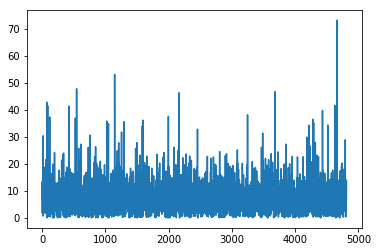

In [180]:
plt.plot(a)

In [183]:
b = a.apply(lambda row: min(row, 200))

In [184]:
c = b.apply(lambda row: max(row, 0))

In [185]:
c.describe()

count    4810.000000
mean        7.288387
std         5.097004
min         0.000000
25%         4.035607
50%         6.521353
75%         9.380384
max        73.087155
Name: 0, dtype: float64

In [174]:
c.to_csv("crazy.txt", index = False)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.
